## Q.41. Cannyエッジ検出 (Step.1) エッジ強度

Q.41 - 43 ではエッジ検出手法の一つであるCanny法の理論となる。

Canny法は、
1. ガウシアンフィルタを掛ける
2. x, y方向のSobelフィルタを掛け、それらからエッジ強度とエッジ勾配を求める
3. エッジ勾配の値から、Non-maximum suppression によりエッジの細線化を行う
4. ヒステリシスによる閾値処理を行う

以上により、画像からエッジ部分を抜き出す手法である。

ここでは、1と2の処理を実装する。

処理手順は、
1. 画像をグレースケール化する
2. ガウシアンフィルタ(5x5, s=1.4)をかける
3. x方向、y方向のsobelフィルタを掛け、画像の勾配画像fx, fyを求め、勾配強度と勾配角度を次式で求める。

```bash
勾配強度 edge = sqrt(fx^2 + fy^2)
勾配角度 angle = arctan(fy / fx)
```

4. 勾配角度を次式に沿って、量子化する。

ただし、angleはradianから角度(degree)にして、-22.5から157.5の範囲をとるように値が修正してから、以下の計算を行う。

```bash
angle = {   0  (if -22.5 < angle <= 22.5)
           45  (if 22.5 < angle <= 67.5)
           90  (if 67.5 < angle <= 112.5)
          135  (if 112.5 < angle <= 157.5)
```

ただし、フィルタリングをパディングする際は、numpy.pad()を用いて、エッジの値でパディングせよ。

|入力 (imori.jpg) |出力(勾配強度) (answers_image/answer_41_1.jpg)|出力(勾配角度) (answers_image/answer_41_2.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_41_1.jpg)|![](answers_image/answer_41_2.jpg)|

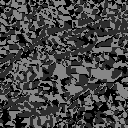

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

## Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

## Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2* (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

## Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
## Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])
        
fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)
## Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

out = angle.astype(np.uint8)

display(Image.fromarray(out))

## Q.42. Cannyエッジ検出 (Step.2) 細線化

ここでは3を実装する。

Q.41で求めた勾配角度から、Non-maximum suppressionを行い、エッジ線を細くする（細線化）。

Non-maximum suppression(NMS)とは非最大値以外を除去する作業の総称である。（他のタスクでもこの名前はよく出る）

ここでは、注目している箇所の勾配角度の法線方向の隣接ピクセルの３つの勾配強度を比較して、最大値ならそのまま値をいじらずに、最大値でなければ強度を0にする、

つまり、勾配強度edge(x,y)に注目している際に、勾配角度angle(x,y)によって次式のようにedge(x,y)を変更する。

```bash
if angle(x,y)  = 0
 if edge(x,y), edge(x-1,y), edge(x+1,y)で edge(x,y)が最大じゃない
  then edge(x,y) = 0
if angle(x,y)  = 45
 if edge(x,y), edge(x-1,y+1), edge(x+1,y-1)で edge(x,y)が最大じゃない
  then edge(x,y) = 0
if angle(x,y)  = 90
 if edge(x,y), edge(x,y-1), edge(x,y+1)で edge(x,y)が最大じゃない
  then edge(x,y) = 0
if angle(x,y)  = 135
 if edge(x,y), edge(x-1,y-1), edge(x+1,y+1)で edge(x,y)が最大じゃない
  then edge(x,y) = 0
```

|入力 (imori.jpg) |出力 (answers_image/answer_42.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_42.jpg)|

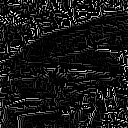

In [2]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

## Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

## Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2* (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

## Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
## Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])
        
fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)

## Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0
            
out = edge.astype(np.uint8)

display(Image.fromarray(out))

## Q.43. Cannyエッジ検出 (Step.3) ヒステリシス閾処理

ここでは4を実装する。これがCanny法の最後である。

ここでは、閾値により勾配強度の二値化を行うがCanny法では二つの閾値(HT: high thoresholdとLT: low threshold)を用いる。

はじめに、
1. 勾配強度edge(x,y)がHT以上の場合はedge(x,y)=255
2. LT以下のedge(x,y)=0
3.  LT < edge(x,y) < HTの時、周り８ピクセルの勾配強度でHTより大きい値が存在すれば、edge(x,y)=255

ここでは、HT=50, LT=20とする。ちなみに閾値の値は結果を見ながら判断するしかない。

以上のアルゴリズムによって、Canny法が行われる。

|入力 (imori.jpg) |出力 (answers_image/answer_43.jpg)|
|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_43.jpg)|

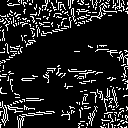

In [3]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

# Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

# Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp(-(x**2 + y**2) / (2 * (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

# Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
# Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)

# Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0


# Histeresis threshold
HT = 100
LT = 30
edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 - Nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):
        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0

edge = _edge[1:H+1, 1:W+1]

out = edge.astype(np.uint8)

display(Image.fromarray(out))

## Q.44. Hough変換・直線検出 (Step.1) Hough変換

Q.44 - 46 ではHough変換を用いた直線検出を行う。

Hough変換とは、座標を直交座標から極座標に変換することにより数式に沿って直線や円など一定の形状を検出する手法である。
ある直線状の点では極座標に変換すると一定のr, tにおいて交わる。
その点が検出すべき直線を表すパラメータであり、このパラメータを逆変換すると直線の方程式を求めることができる。

方法としては、
1. エッジ画像(ここではCannyの出力)からエッジのピクセルにおいてHough変換を行う。
2. Hough変換後の値のヒストグラムをとり、極大点を選ぶ。
3. 極大点のr, tの値をHough逆変換して検出した直線のパラメータを得る。

となる。

ここでは、1のHough変換を行いヒストグラムを作成する。

アルゴリズムは、

1. 画像の対角線の長さrmaxを求める。
2. エッジ箇所(x,y)において、t = 0-179で一度ずつtを変えながら、次式によりHough変換を行う。

```bash
rho = x * cos(t) + y * sin(t)
```
3. 「ボーティング（投票）」 [2 x rmax, 180]のサイズの表を用意し、1で得たtable(rho, t) に1を足す。２で求めたrhoは[-rmax, rmax]の範囲を取るので、ボーティングの時には注意！

ボーティングでは、一定の箇所に集中する。

今回は*torino.jpg*を用いて、ボーディングした表を図示せよ。
Cannyのパラメータは, gaussian filter(5x5, s=1.4), HT = 100, LT = 30で使用せよ。

|入力 (thorino.jpg) |出力 (answers_image/answer_44.jpg)|
|:---:|:---:|
|![](thorino.jpg)|![](answers_image/answer_44.jpg)|

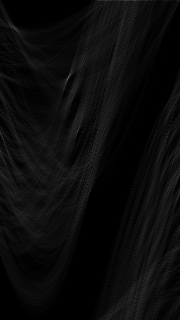

In [4]:
# Read image
img = cv2.imread("./thorino.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

## Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

## Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2* (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

## Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
## Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])
        
fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)

## Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0


# Histeresis threshold
HT = 100
LT = 30
edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

## 8 - Nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):
        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0

edge = _edge[1:H+1, 1:W+1].astype(np.uint8)
            
## Canny finish

# Hough

## Voting
drho = 1
dtheta = 1
rho_max = np.ceil(np.sqrt(H**2 + W**2)).astype(int)
hough = np.zeros((rho_max, 180), dtype=int)

ind = np.where(edge == 255)

## hough transformation
for y, x in zip(ind[0], ind[1]):
    for theta in range(0, 180, dtheta):
        t = np.pi / 180 * theta
        rho = int(x * np.cos(t) + y * np.sin(t))
        hough[rho, theta] += 1
          
out = hough.astype(np.uint8)

display(Image.fromarray(out))

## Q.45. Hough変換・直線検出 (Step.2) NMS

ここでは2を実装する。

Q.44で得られた表では、ある一定の箇所付近に多く投票される。
ここでは、その付近の極大値を抜き出す操作を行え。

今回はボーディングが多い箇所を上位20個抜き出し、図示せよ。(C++の解答は上位30個にしてます。なんか20だと同じような結果にらなかったので、、)

NMSのアルゴリズムは、
1. 表において、周囲8マス(8近傍)より注目ピクセルの得票数が多ければそのまま。
2. 注目ピクセルの値が少なければ0にする。

|入力 (thorino.jpg) |出力 (answers_image/answer_45.jpg)|
|:---:|:---:|
|![](thorino.jpg)|![](answers_image/answer_45.jpg)|

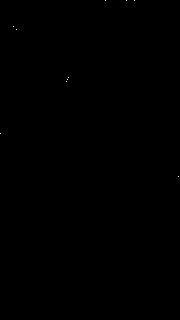

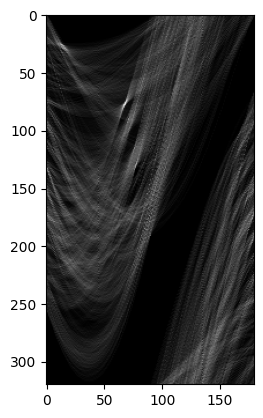

In [5]:
# Read image
img = cv2.imread("./thorino.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

## Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

## Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp( -(x**2 + y**2) / (2* (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

## Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
## Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])
        
fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)
## Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0


# Histeresis threshold
HT = 100
LT = 30
edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

## 8 - Nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):
        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0

edge = _edge[1:H+1, 1:W+1].astype(np.uint8)

## Canny finish

# Hough

## Voting
drho = 1
dtheta = 1
rho_max = np.ceil(np.sqrt(H**2 + W**2)).astype(int)
hough = np.zeros((rho_max, 180), dtype=int)

ind = np.where(edge == 255)

## hough transformation
for y, x in zip(ind[0], ind[1]):
    for theta in range(0, 180, dtheta):
        t = np.pi / 180 * theta
        rho = int(x * np.cos(t) + y * np.sin(t))
        hough[rho, theta] += 1

plt.imshow(hough, cmap='gray')

## non maximum suppression
for y in range(rho_max):
    for x in range(180):
        x1 = max(x-1, 0)
        x2 = min(x+2, 180)
        y1 = max(y-1, 0)
        y2 = min(y+2, rho_max)
        if np.max(hough[y1:y2, x1:x2]) == hough[y,x] and hough[y, x] != 0:
            pass
            #hough[y,x] = 255
        else:
            hough[y,x] = 0
ind_x = np.argsort(hough.ravel())[::-1][:10]
ind_y = ind_x.copy()
thetas = ind_x % 180
rhos = ind_y // 180
_hough = np.zeros_like(hough, dtype=int)
_hough[rhos, thetas] = 255
        
out = _hough.astype(np.uint8)

display(Image.fromarray(out))

## Q.46. Hough変換・直線検出 (Step.3) Hough逆変換

ここではQ.45.で得られた極大値をHough逆変換をして直線を描画する。これで、Hough変換による直線検出が完了する。

アルゴリズムは、
1. 極大点(r, t)を次式で逆変換する。

```bash
y = - cos(t) / sin(t) * x + r / sin(t)
x = - sin(t) / cos(t) * y + r / cos(t)
```

2. 1の逆変換を極大点ごとにy = 0 - H-1, x = 0 - W-1 で行い、入力画像に検出した直線を描画せよ。
ただし、描画するのは赤線(R,G,B) = (255, 0, 0)とする。

|入力 (thorino.jpg) |出力 (answers_image/answer_46.jpg)|
|:---:|:---:|
|![](thorino.jpg)|![](answers_image/answer_46.jpg)|

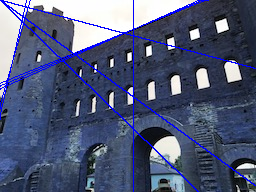

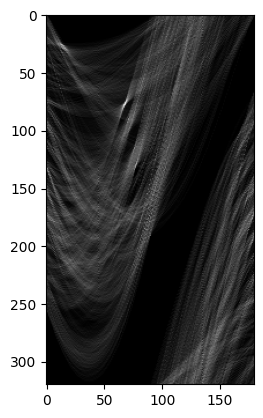

In [6]:
# Read image
img = cv2.imread("thorino.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

# Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

# Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp(-(x**2 + y**2) / (2 * (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

# Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
# Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)
# Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0


# Histeresis threshold
HT = 100
LT = 30
edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 - Nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):
        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0

edge = _edge[1:H+1, 1:W+1].astype(np.uint8)

# Canny finish

# Hough

# Voting
drho = 1
dtheta = 1
rho_max = np.ceil(np.sqrt(H**2 + W**2)).astype(int)
hough = np.zeros((rho_max, 180), dtype=int)

ind = np.where(edge == 255)

# hough transformation
for y, x in zip(ind[0], ind[1]):
    for theta in range(0, 180, dtheta):
        t = np.pi / 180 * theta
        rho = int(x * np.cos(t) + y * np.sin(t))
        hough[rho, theta] += 1

plt.imshow(hough, cmap='gray')

# non maximum suppression
for y in range(rho_max):
    for x in range(180):
        x1 = max(x-1, 0)
        x2 = min(x+2, 180)
        y1 = max(y-1, 0)
        y2 = min(y+2, rho_max)
        if np.max(hough[y1:y2, x1:x2]) == hough[y, x] and hough[y, x] != 0:
            pass
            #hough[y,x] = 255
        else:
            hough[y, x] = 0
ind_x = np.argsort(hough.ravel())[::-1][:10]
ind_y = ind_x.copy()
thetas = ind_x % 180
rhos = ind_y // 180
#_hough = np.zeros_like(hough, dtype=np.int)
#_hough[rhos, thetas] = 255

# Inverse hough transformation

out = img.copy()

for theta, rho in zip(thetas, rhos):
    t = np.pi / 180. * theta
    for x in range(W):
        if np.sin(t) != 0:
            y = - (np.cos(t) / np.sin(t)) * x + rho / np.sin(t)
            y = int(y)
            if y >= H or y < 0:
                continue
            out[y, x] = [0, 0, 255]
    for y in range(H):
        if np.cos(t) != 0:
            x = - (np.sin(t) / np.cos(t)) * y + rho / np.cos(t)
            x = int(x)
            if x >= W or x < 0:
                continue
            out[y, x] = [0, 0, 255]

out = out.astype(np.uint8)

display(Image.fromarray(out))

## Q.47. モルフォロジー処理(膨張)

Morphology Dilate

*imori.jpg*を大津の二値化したものに、モルフォロジー処理による膨張を2回行え。

モルフォロジー処理とは二値化画像の白(255)マス部分を4近傍(上下左右1マス)に膨張、または1マスだけ収縮させる処理をいう。

この膨張と収縮を何度も繰り返すことで1マスだけに存在する白マスを消したり(Q.49. オープニング処理)、本来つながってほしい白マスを結合させたりできる(Q.50. クロージング処理)。

モルフォロジー処理の膨張(Dilation)アルゴリズムは、
注目画素I(x, y)=0で、I(x, y-1), I(x-1, y), I(x+1, y), I(x, y+1)のどれか一つが255なら、I(x, y) = 255 とする。

<img src='assets/morphology_erode.png' width=300>

つまり、上の処理を2回行えば2マス分膨張できることになる。

モルフォロジー処理の実装は例えば、[[0,1,0], [1,0,1], [0,1,0]] のフィルタを掛けた和が255以上なら膨張である、と考えることもできる。

|入力 (imori.jpg) |大津の二値化(answers_image/answer_4.jpg)|出力 (answers_image/answer_47.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_4.jpg)|![](answers_image/answer_47.jpg)|

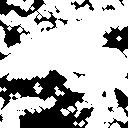

In [7]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Otsu binary
## Grayscale
out = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
out = out.astype(np.uint8)

## Determine threshold of Otsu's binarization
max_sigma = 0
max_t = 0

for _t in range(1, 255):
    v0 = out[np.where(out < _t)]
    m0 = np.mean(v0) if len(v0) > 0 else 0.
    w0 = len(v0) / (H * W)
    v1 = out[np.where(out >= _t)]
    m1 = np.mean(v1) if len(v1) > 0 else 0.
    w1 = len(v1) / (H * W)
    sigma = w0 * w1 * ((m0 - m1) ** 2)
    if sigma > max_sigma:
        max_sigma = sigma
        max_t = _t

## Binarization
#print("threshold >>", max_t)
th = max_t
out[out < th] = 0
out[out >= th] = 255


# Morphology - dilate
Dil_time = 2
MF = np.array(((0, 1, 0),
               (1, 0, 1),
               (0, 1, 0)), dtype=int)


for i in range(Dil_time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                out[y-1, x-1] = 255

display(Image.fromarray(out))

## Q.48. モルフォロジー処理(収縮)

*imori.jpg*を大津の二値化したものに、モルフォロジー処理による収縮を2回行え。

モルフォロジー処理の収縮(Erosion)アルゴリズムは、
注目画素I(x, y)=255で、I(x, y-1), I(x-1, y), I(x+1, y), I(x, y+1)のどれか一つでも0なら、I(x, y) = 0 とする。

<img src='assets/morphology_dilate.png' width=300>

収縮処理は例えば、[[0,1,0], [1,0,1], [0,1,0]] のフィルタを掛けた和が255*4未満なら収縮である、と考えることもできる。

|入力 (imori.jpg) |大津の二値化(answers_image/answer_4.jpg)|出力 (answers_image/answer_48.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_4.jpg)|![](answers_image/answer_48.jpg)|

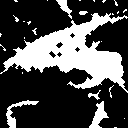

In [8]:
# Read image
img = cv2.imread("./imori.jpg").astype(np.float32)
H, W, C = img.shape

# Otsu binary
# Grayscale
out = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
out = out.astype(np.uint8)

# Determine threshold of Otsu's binarization
max_sigma = 0
max_t = 0

for _t in range(1, 255):
    v0 = out[np.where(out < _t)]
    m0 = np.mean(v0) if len(v0) > 0 else 0.
    w0 = len(v0) / (H * W)
    v1 = out[np.where(out >= _t)]
    m1 = np.mean(v1) if len(v1) > 0 else 0.
    w1 = len(v1) / (H * W)
    sigma = w0 * w1 * ((m0 - m1) ** 2)
    if sigma > max_sigma:
        max_sigma = sigma
        max_t = _t

# Binarization
#print("threshold >>", max_t)
th = max_t
out[out < th] = 0
out[out >= th] = 255


# Morphology filter
MF = np.array(((0, 1, 0),
               (1, 0, 1),
               (0, 1, 0)), dtype=int)

# Morphology - erode
Erode_time = 2

for i in range(Erode_time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                out[y-1, x-1] = 0

display(Image.fromarray(out))

## Q.49. オープニング処理

**大津の二値化後**に、オープニング処理(N=1)を行え。

オープニング処理とは、モルフォロジー処理の収縮をN回行った後に膨張をN回行う処理である。

<img src='assets/morphology_opening.png' width=400>

オープニング処理により、一つだけ余分に存在する画素などを削除できる。

|入力 (imori.jpg) |大津の二値化(answers_image/answer_4.jpg)|出力 (answers_image/answer_49.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_4.jpg)|![](answers_image/answer_49.jpg)|

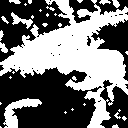

In [9]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Otsu binary
# Grayscale
out = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
out = out.astype(np.uint8)

# Determine threshold of Otsu's binarization
max_sigma = 0
max_t = 0

for _t in range(1, 255):
    v0 = out[np.where(out < _t)]
    m0 = np.mean(v0) if len(v0) > 0 else 0.
    w0 = len(v0) / (H * W)
    v1 = out[np.where(out >= _t)]
    m1 = np.mean(v1) if len(v1) > 0 else 0.
    w1 = len(v1) / (H * W)
    sigma = w0 * w1 * ((m0 - m1) ** 2)
    if sigma > max_sigma:
        max_sigma = sigma
        max_t = _t

# Binarization
#print("threshold >>", max_t)
th = max_t
out[out < th] = 0
out[out >= th] = 255

# Morphology filter
MF = np.array(((0, 1, 0),
               (1, 0, 1),
               (0, 1, 0)), dtype=int)

# Morphology - erode
Erode_time = 1

for i in range(Erode_time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                out[y-1, x-1] = 0

# Morphology - dilate
Dil_time = 1

for i in range(Dil_time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                out[y-1, x-1] = 255

display(Image.fromarray(out))

## Q.50. クロージング処理

**Canny検出した後**に、クロージング処理(N=1)を行え。

クロージング処理とは、モルフォロジー処理の膨張をN回行った後に収縮をN回行う処理である。

<img src='assets/morphology_closing.png' width=400>

クロージング処理により、途中で途切れた画素を結合することができる。

|入力 (imori.jpg) |Canny(answers_image/answer_43.jpg)|出力 (answers_image/answer_50.jpg)|
|:---:|:---:|:---:|
|![](imori.jpg)|![](answers_image/answer_43.jpg)|![](answers_image/answer_50.jpg)|

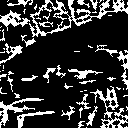

In [10]:
# Read image
img = cv2.imread("imori.jpg").astype(np.float32)
H, W, C = img.shape

# Gray
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Gaussian Filter
K_size = 5
sigma = 1.4

# Zero padding
pad = K_size // 2
gau = np.zeros((H + pad*2, W + pad*2), dtype=np.float32)
#gau[pad:pad+H, pad:pad+W] = gray.copy().astype(np.float32)
gau = np.pad(gray, (pad, pad), 'edge')
tmp = gau.copy()

# Kernel
K = np.zeros((K_size, K_size), dtype=np.float32)
for x in range(-pad, -pad+K_size):
    for y in range(-pad, -pad+K_size):
        K[y+pad, x+pad] = np.exp(-(x**2 + y**2) / (2 * (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        gau[pad+y, pad+x] = np.sum(K * tmp[y:y+K_size, x:x+K_size])

# Sobel vertical
KSV = np.array(((-1., -2., -1.), (0., 0., 0.), (1., 2., 1.)), dtype=np.float32)
# Sobel horizontal
KSH = np.array(((-1., 0., 1.), (-2., 0., 2.), (-1., 0., 1.)), dtype=np.float32)

gau = gau[pad-1:H+pad+1, pad-1:W+pad+1]
fy = np.zeros_like(gau, dtype=np.float32)
fx = np.zeros_like(gau, dtype=np.float32)
K_size = 3
pad = K_size // 2

for y in range(H):
    for x in range(W):
        fy[pad+y, pad+x] = np.sum(KSV * gau[y:y+K_size, x:x+K_size])
        fx[pad+y, pad+x] = np.sum(KSH * gau[y:y+K_size, x:x+K_size])

fx = fx[pad:pad+H, pad:pad+W]
fy = fy[pad:pad+H, pad:pad+W]

# Non-maximum suppression
edge = np.sqrt(np.power(fx, 2) + np.power(fy, 2))
fx[fx == 0] = 1e-5
tan = np.arctan(fy / fx)
# Angle quantization
angle = np.zeros_like(tan, dtype=np.uint8)
angle[np.where((tan > -0.4142) & (tan <= 0.4142))] = 0
angle[np.where((tan > 0.4142) & (tan < 2.4142))] = 45
angle[np.where((tan >= 2.4142) | (tan <= -2.4142))] = 95
angle[np.where((tan > -2.4142) & (tan <= -0.4142))] = 135

for y in range(H):
    for x in range(W):
        if angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == W-1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == H-1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if max(max(edge[y, x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y, x]:
            edge[y, x] = 0


# Histeresis threshold
HT = 100
LT = 30
edge[edge >= HT] = 255
edge[edge <= LT] = 0

_edge = np.zeros((H+2, W+2), dtype=np.float32)
_edge[1:H+1, 1:W+1] = edge

# 8 - Nearest neighbor
nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

for y in range(1, H+2):
    for x in range(1, W+2):
        if _edge[y, x] < LT or _edge[y, x] > HT:
            continue
        if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
            _edge[y, x] = 255
        else:
            _edge[y, x] = 0

edge = _edge[1:H+1, 1:W+1]

out = edge.astype(np.uint8)


# Morphology filter
MF = np.array(((0, 1, 0),
               (1, 0, 1),
               (0, 1, 0)), dtype=int)

# Morphology - dilate
Dil_time = 1

for i in range(Dil_time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) >= 255:
                out[y-1, x-1] = 255

# Morphology - erode
Erode_time = 1

for i in range(Erode_time):
    tmp = np.pad(out, (1, 1), 'edge')
    for y in range(1, H+1):
        for x in range(1, W+1):
            if np.sum(MF * tmp[y-1:y+2, x-1:x+2]) < 255*4:
                out[y-1, x-1] = 0
                
display(Image.fromarray(out))